# Task 3 Confounders in AI
## Outline
1. Introduction to Confounders
- Definition
- Importance, why are they significant in AI and how can they influence outcomes
2. Confounders in AI
- Impact on AI models, how can confounders affect accuracy and reliability
- Examples, where confounders notably skewed AI model results
3. Addressing Confounders
- Methods of adjustment, common techniques
- Benefits of addressing confounders
4. Case Study 
- Select a technique to Adjust for confounders
- Discuss the techniques application
- Discussion and Example of this techniwue applied in a real AI project
5. Conclusion
- Summary
- Implications for future AI Development


## Sources
1. Pneumothorax Detection in Chest Radiographs:
- Link: [PDF](../../Books/s00330-021-07833-w.pdf)
- Summary: How can AI models be affected by noisy data and confounders focusing on medical imaging
2. Uncovering Interpretable Potential Confounders in Electronic Medical Records:
- Link: [PDF](../../Books/s41467-022-28546-8.pdf)
- Summary: Methods to uncover potential confounders in AI within healthcare, emphasizing interoretability
3. Confounders Mediate AI Prediction of Demographics in Medical Imaging:
- Link: [PDF](../../Books/s41746-022-00720-8.pdf)
- Summary: Role of confounders in skewing AI predictions
4. Measuring the Effects of Confounders in Medical Supervised Classification Problems: The Confounding Index (CI):
- Link: [PDF](../../Books/1-s2.0-S0933365719303410-main.pdf)
- Summary: Introduces the Confounding Index to measure the impact of confounders in machine learning models
5. Dealing with Confounders and Outliers in Classification Medical Studies:
- Link: [PDF](../../Books/1-s2.0-S0933365719306086-main.pdf)
- Summary: Methods to identify variables that could be confounders to the learning process in medical AI studies

In [196]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, r2_score

from causalml.match import NearestNeighborMatch

from dowhy import CausalModel

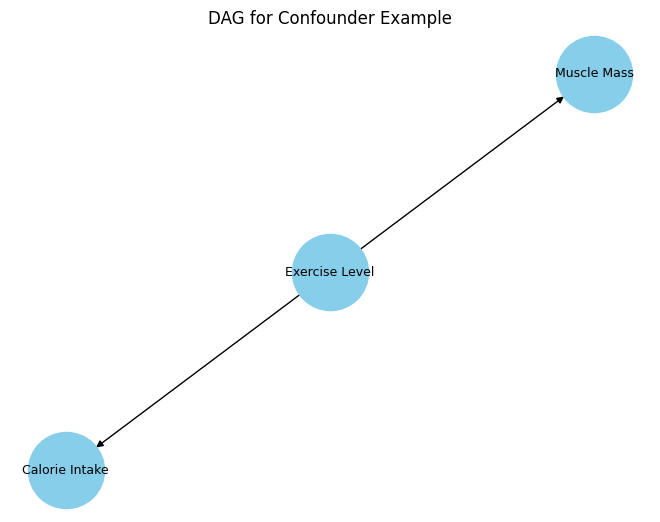

In [197]:
G = nx.DiGraph()
G.add_edges_from([("Exercise Level", "Muscle Mass"), ("Exercise Level", "Calorie Intake")])

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', edge_color='k', linewidths=1, font_size=9)
plt.title('DAG for Confounder Example')
plt.show()

In [198]:
# Data generation
np.random.seed(73)
datasize = 100

exercise_level = np.random.randint(1, 11, datasize) # rated from 1 to 10
muscle_mass = 0.42 + exercise_level * 0.05 + np.random.normal(0, 0.01, datasize) # higher exercise level leads to higher muscle mass (50% to 92% of body weight)
muscle_mass = np.clip(muscle_mass, 0.5, 0.92)
calorie_intake = exercise_level * 400 + np.random.normal(0, 300, datasize) # higher exercise level leads to higher calorie intake (1000 to 5000 kcal)
calorie_intake = np.clip(calorie_intake, 1000, 5000) 

data = pd.DataFrame({'exercise_level': exercise_level, 'muscle_mass': muscle_mass, 'calorie_intake': calorie_intake})
print(data.head())

   exercise_level  muscle_mass  calorie_intake
0               7     0.766799     2872.911073
1               3     0.584012     1000.000000
2               1     0.500000     1000.000000
3               9     0.879899     3955.997963
4               4     0.619720     1155.605848


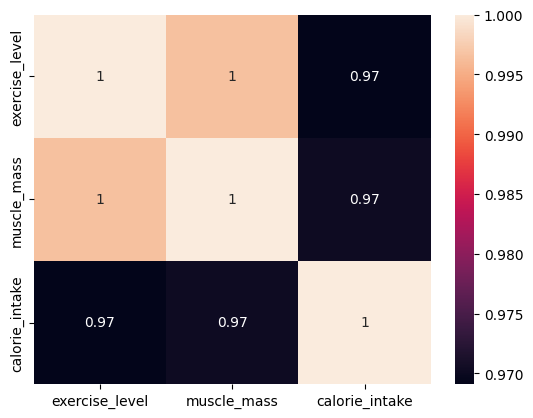

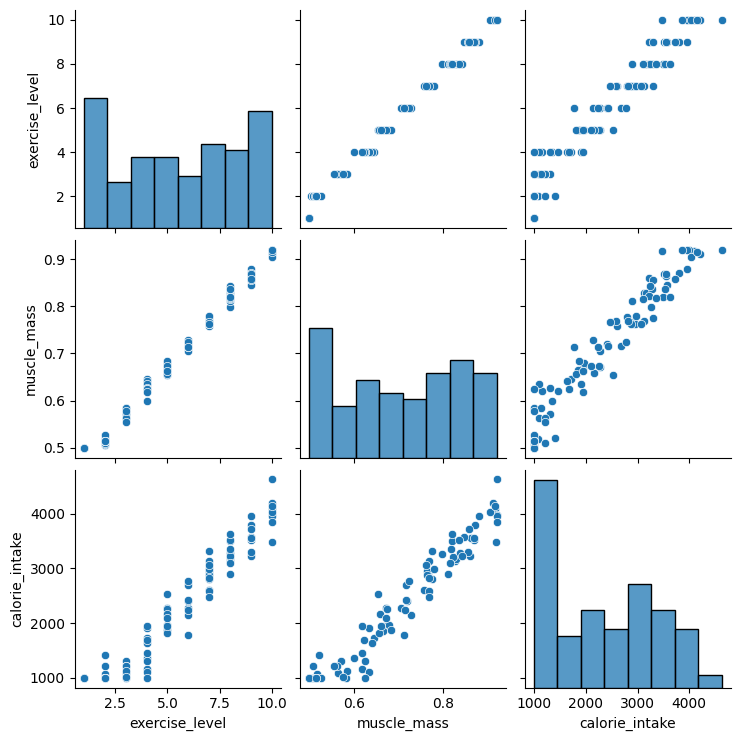

In [199]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
sns.pairplot(data)
plt.show()

In [200]:
# Linear regression model 1: calorie intake only
X_1 = data[['calorie_intake']]
y = data['muscle_mass']

model_1 = LinearRegression()
model_1.fit(X_1, y)
pred_1 = model_1.predict(X_1)
r2_1 = r2_score(y, pred_1)

print("Model 1: Calorie Intake Only")
print("Coefficient:", model_1.coef_)
print("Intercept:", model_1.intercept_)
print("R^2 for model 1:", r2_1)

Model 1: Calorie Intake Only
Coefficient: [0.00012364]
Intercept: 0.41429266355759475
R^2 for model 1: 0.9413150287340556


In [201]:
# Linear regression model 2: exercise_level intake only
X_3 = data[['exercise_level']]
y = data['muscle_mass']

model_3 = LinearRegression()
model_3.fit(X_3, y)
pred_3 = model_3.predict(X_3)
r2_3 = r2_score(y, pred_3)

print("Model 1: Calorie Intake Only")
print("Coefficient:", model_3.coef_)
print("Intercept:", model_3.intercept_)
print("R^2 for model 1:", r2_3)

Model 1: Calorie Intake Only
Coefficient: [0.04891771]
Intercept: 0.42624678861058163
R^2 for model 1: 0.9931319657559496


In [202]:
# Linear regression model 2: calorie intake and exercise level (Mulitiple Regression)
X_2 = data[['calorie_intake', 'exercise_level']]

model_2 = LinearRegression()
model_2.fit(X_2, y)
pred_2 = model_2.predict(X_2)
r2_2 = r2_score(y, pred_2)

print("Model 2: Calorie Intake and Exercise Level")
print("Coefficient:", model_2.coef_)
print("Intercept:", model_2.intercept_)
print("R^2 for model 2:", r2_2)


Model 2: Calorie Intake and Exercise Level
Coefficient: [9.31534679e-06 4.54405721e-02]
Intercept: 0.4241776009198306
R^2 for model 2: 0.9934570573463918


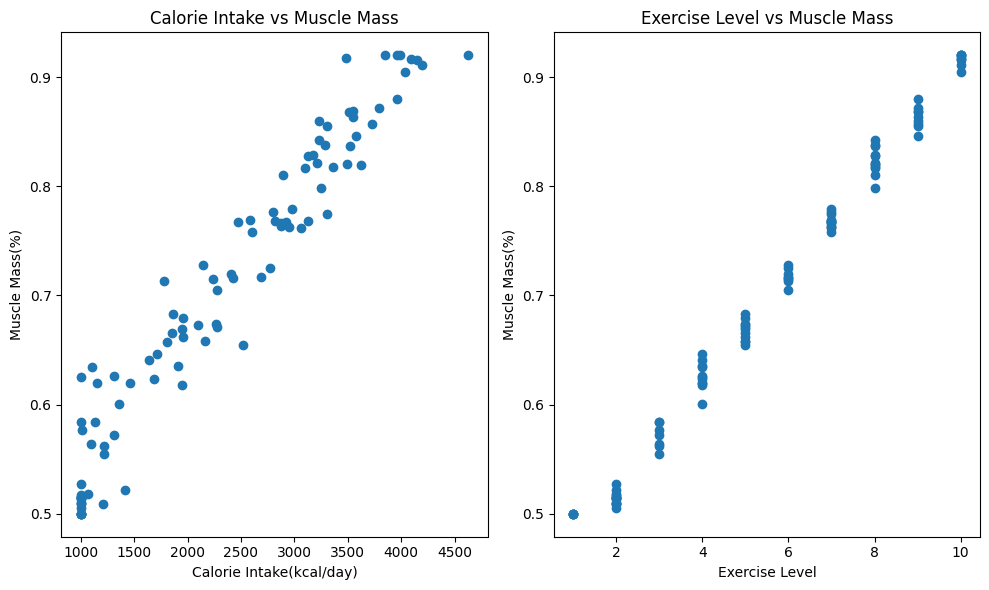

In [203]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.scatter(data['calorie_intake'], data['muscle_mass'])
plt.xlabel('Calorie Intake(kcal/day)')
plt.ylabel('Muscle Mass(%)')
plt.title('Calorie Intake vs Muscle Mass')

plt.subplot(1, 2, 2)
plt.scatter(data['exercise_level'], data['muscle_mass'])
plt.xlabel('Exercise Level')
plt.ylabel('Muscle Mass(%)')
plt.title('Exercise Level vs Muscle Mass')

plt.tight_layout()
plt.show()

In [204]:
# Linear regression model 3: Propensity Score Matching
# Discretize calorie intake for binary treatment (simplification for PSM)
data['high_calorie'] = (data['calorie_intake'] > data['calorie_intake'].median()).astype(int)
                                                                                         
# Calculate propensity scores using logistic regression
X_prop = data[['exercise_level']]
y_prop = data['high_calorie']
propensity_model = LogisticRegression()
propensity_model.fit(X_prop, y_prop)
data['propensity_score'] = propensity_model.predict_proba(X_prop)[:, 1]

# Perform nearest neighbor matching
matcher = NearestNeighborMatch(replace=False, ratio=1, random_state=73)
matched_indices = matcher.match(data, 'high_calorie', ['propensity_score'])

# Create matched dataset
matched_data = data.loc[matched_indices.index].reset_index(drop=True)

# Analyze the effect of calorie intake on muscle mass in matched groups
X_matched = matched_data[['high_calorie']]
y_matched = matched_data['muscle_mass']
model_matched = LinearRegression().fit(X_matched, y_matched)
preds_matched = model_matched.predict(X_matched)
r2_matched = r2_score(y_matched, preds_matched)

print("Matched Model: High Calorie Intake")
print("Coefficient:", model_matched.coef_)
print("Intercept:", model_matched.intercept_)
print("R-squared:", r2_matched)      

# Analyze the effect of calorie intake on muscle mass in matched groups
X_matched = matched_data[['exercise_level', 'high_calorie']]
y_matched = matched_data['muscle_mass']
model_matched = LinearRegression().fit(X_matched, y_matched)
preds_matched = model_matched.predict(X_matched)
r2_matched = r2_score(y_matched, preds_matched)

print()
print("Matched Model: High Calorie Intake")
print("Coefficient:", model_matched.coef_)
print("Intercept:", model_matched.intercept_)
print("R-squared:", r2_matched)      

Matched Model: High Calorie Intake
Coefficient: [-0.00535306]
Intercept: 0.6999265317622846
R-squared: 0.01105992596199512

Matched Model: High Calorie Intake
Coefficient: [ 0.04965298 -0.00535306]
Intercept: 0.4218698498188772
R-squared: 0.9245642896661269


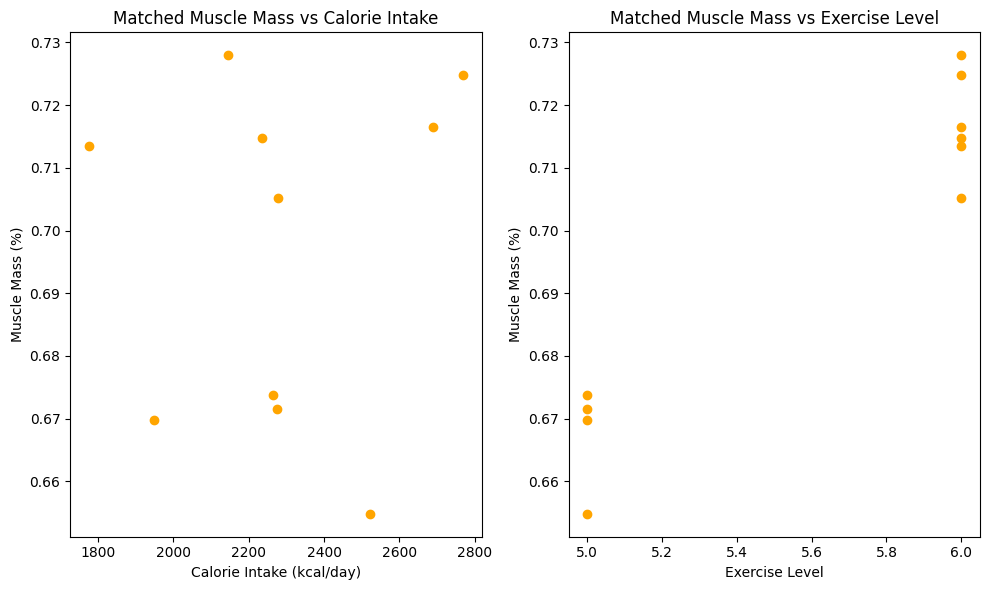

In [205]:



plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.scatter(matched_data['calorie_intake'], matched_data['muscle_mass'], color='orange')
plt.xlabel('Calorie Intake (kcal/day)')
plt.ylabel('Muscle Mass (%)')
plt.title('Matched Muscle Mass vs Calorie Intake')

plt.subplot(1, 2, 2)
plt.scatter(matched_data['exercise_level'], matched_data['muscle_mass'], color='orange')
plt.xlabel('Exercise Level')
plt.ylabel('Muscle Mass (%)')
plt.title('Matched Muscle Mass vs Exercise Level')

plt.tight_layout()
plt.show()

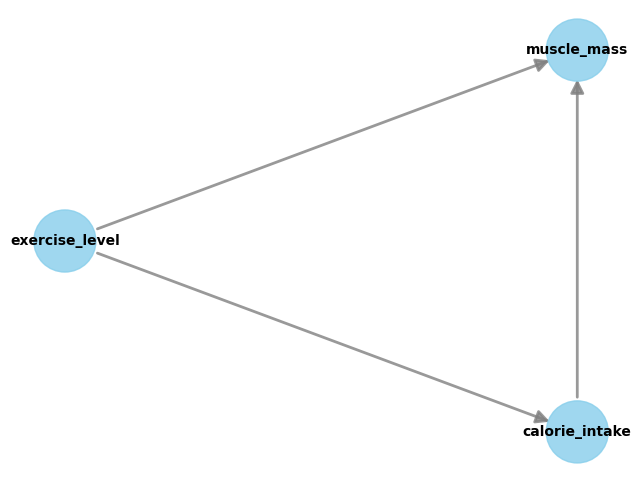

Causal Estimate is 9.315346788385526e-06
Refute: Add a random common cause
Estimated effect:9.315346788385526e-06
New effect:9.273228125400434e-06
p value:0.98



In [206]:
# DoWhy
model_do_why = CausalModel(
    data=data,
    treatment='calorie_intake',
    outcome='muscle_mass',
    common_causes=['exercise_level'],
    instruments=None
)

model_do_why.view_model()

identified_estimand = model_do_why.identify_effect()
estimate = model_do_why.estimate_effect(identified_estimand, method_name='backdoor.linear_regression')

print(f"Causal Estimate is {estimate.value}")

refute_results = model_do_why.refute_estimate(identified_estimand, estimate, method_name='random_common_cause')
print(refute_results)

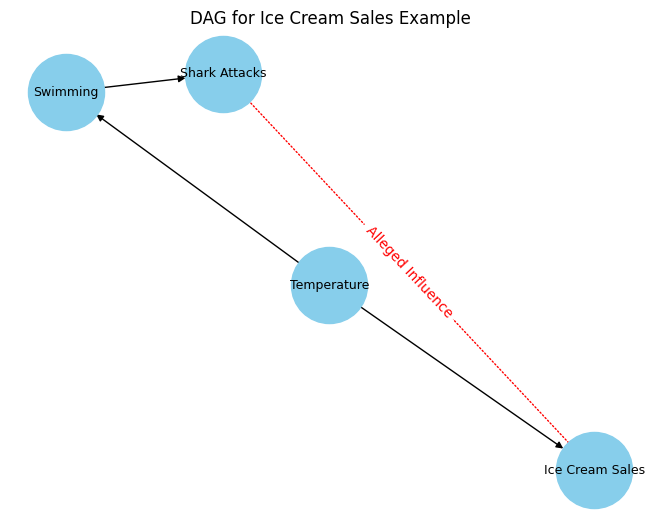

In [207]:
G = nx.DiGraph()
G.add_edges_from([("Temperature", "Ice Cream Sales"), ("Temperature", "Swimming"), ("Swimming", "Shark Attacks")])

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', edge_color='k', linewidths=1, font_size=9)
nx.draw_networkx_edges(G, pos, edgelist=[("Ice Cream Sales", "Shark Attacks")], style="dotted", edge_color='r')
nx.draw_networkx_edge_labels(G, pos, edge_labels={("Ice Cream Sales", "Shark Attacks"): 'Alleged Influence'}, font_color='red')

plt.title('DAG for Ice Cream Sales Example')
plt.show()

# Paper Sketch
## Outline
### 1. Introduction to Confounders
#### - Definition: 
Clarify what confounders are—variables that influence both the dependent and independent variables, leading to potential bias in the estimation of the effect of the independent variable.
#### - Importance: 
Explain why confounders are critical in AI:
* They can lead to biased results and erroneous conclusions if not properly accounted for.
* Addressing them enhances the accuracy and reliability of AI predictions, particularly in healthcare.
### 2. Confounders in AI
#### - Impact on AI Models:
* Confounders can skew the relationships models learn, affecting their ability to generalize and potentially leading to incorrect decisions.
* Examples of AI systems failing in real-world applications due to ignored confounders.
#### - Examples:
Case studies from published research where not addressing confounders led to significantly different outcomes.
### 3. Addressing Confounders
#### - Methods of Adjustment:
* Common techniques such as stratification, matching, regression adjustment, and more sophisticated methods like propensity score matching.
* Use of causal inference frameworks, like doWhy, to explicitly model and adjust for confounders.
#### - Benefits:
* Improved model integrity and decision-making accuracy.
* Enhanced credibility and acceptance of AI systems among users and stakeholders.
### 4. Case Study
#### - Technique Selection:
* Choose propensity score matching as the technique for adjusting confounders, explaining its applicability and effectiveness.
Technique Application:
* Detailed step-by-step description of applying propensity score matching to the synthetic dataset involving cholesterol, smoking, and CVD risk.
* Discussion and Example Application:
* Results of the case study, including ROC AUC scores and causal estimates.
* Visualization of the causal relationship using NetworkX and its impact on understanding the data.
### 5. Conclusion
#### - Summary:
* Recap the importance of confounder adjustment, key findings from the case study, and how the example illustrates broader implications for AI development.
* Implications for Future AI Development:
The need for integrating causal analysis in the AI model development process.
Suggestions for ongoing research to explore additional confounders and extend findings to more complex and varied datasets.